In [1]:
import sys
sys.path.append("../implementations")
from classes.frameworks import Frameworks
import copy
import os
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm
from collections import defaultdict
import numpy as np
import dill
import os
frameworks = defaultdict(dict)
memo_dir = "./data/memo/"
origin_models_dir = "./data/origin_models/"
all_experiments = {
    "memo": memo_dir,
    "origin_models": origin_models_dir,
}

In [5]:
backends = ["tensorflow_new"]
def get_coverage(file_dir):
    arc_coverage = []
    api_coverage = defaultdict(list)
    arc_time = []
    file_list = ["tensorflow_new_api_cov.txt", "tensorflow_new_arcs.txt"]
    with open(os.path.join(file_dir, "tensorflow_new_arcs.txt"), "r") as file:
        content = file.read().split("\n")[:-1]
    for i, line in enumerate(content):
        if "Current time" in line:
            arc_time.append(float(line.split(": ")[-1]))
        if "arcs result" in line:
            arc_coverage.append(float(content[i+1]))
    time = []
    with open(os.path.join(file_dir, "tensorflow_new_api_cov.txt"), "r") as file:
        content = file.read().split("\n")[:-1]
    for i, line in enumerate(content):
        if "Current time" in line:
            time.append(float(line.split(": ")[-1]))
        if "api coverage result" in line:
            api_coverage["api_input"].append(float(content[i+1].split("; ")[3]))
            api_coverage["api_sequence"].append(float(content[i+1].split("; ")[1]))
            api_coverage["api_param"].append(float(content[i+1].split("; ")[2]))
    
    return time, arc_time, arc_coverage, api_coverage["api_input"], api_coverage["api_sequence"], api_coverage["api_param"]


def get_branch(file_path):
    backend = ["tensorflow_new"]
    result_dict = {}
    for bk in backend:
        print("========= working on backend: {} ========".format(bk))
        result_dict[bk] = {}
        result_dict[bk]["time"], result_dict[bk]["arc_time"], result_dict[bk]["arcs"], \
        result_dict[bk]["api_input"], result_dict[bk]["api_sequence"], result_dict[bk]["api_param"] \
        = get_coverage(file_path)
    return result_dict

# exps = ["alexnet-cifar10"]
def get_all_result(experiment_dir):
    result_list = []
    result_list.append(get_branch(experiment_dir))
    return result_list
    
result_memo = get_all_result(all_experiments["memo"])

result_complicate = get_all_result(all_experiments["origin_models"])


========= working on backend: tensorflow_new ========
========= working on backend: tensorflow_new ========


## Plot Coverage Trends

Working on coverage: api_input
api_input 888 0.6971279373368147
api_input 568 0.5861618798955613
Working on coverage: api_param
api_param 888 0.5017081503172279
api_param 568 0.3904343582235237
Working on coverage: api_sequence
api_sequence 888 0.1884606816662954
api_sequence 568 0.12207618623301403


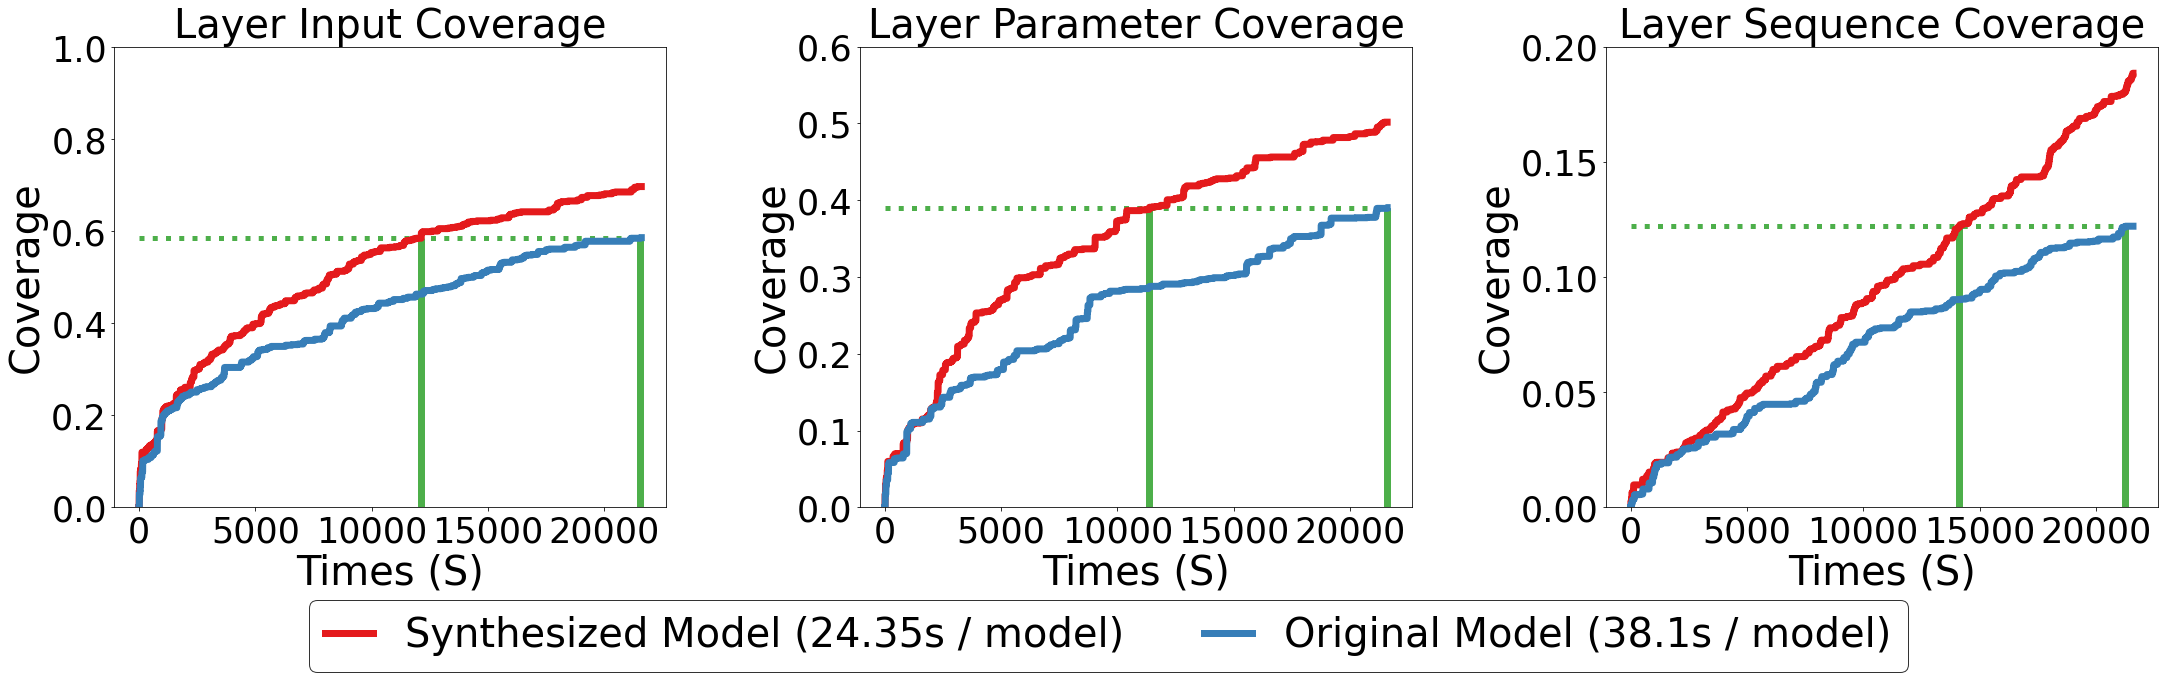

In [6]:
# Draw four graph, each graph represent the test coverage of one framework
import numpy as np
color_list = []
cmap = cm.get_cmap("Set2", 3)
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    color_list.append(matplotlib.colors.rgb2hex(rgb))
memo_color = "#e41a1c"
complicate_color = "#377eb8"
average_branch_color = "#4daf4a"

fig = plt.figure(figsize=(50,8))
ATITLE_SIZE = 40
LABEL_SIZE = 40
XTICK_SIZE = 35
YTICK_SIZE = 35
LEGEND_SIZE = 40
FTITLA_SIZE = 30
SCATTER_FONT_SIZE = 14
SCATTER_LINE_SIZE = 2.5
SCATTER_AREA = 100

# plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=ATITLE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=XTICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=YTICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FTITLA_SIZE)  # fontsize of the figure title

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.35   # the amount of width reserved for blank space between subplots
hspace = 0.2   # the amount of height reserved for white space between subplots

plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top, wspace=wspace, hspace=hspace)
cov_list = [
#     "arcs", 
    "api_input", 
    "api_param", 
    "api_sequence"
]
# result: [{"tensorflow_new": {"py": {"linehit": []}, "branchhit": }, "c":{}, "time": []}, {"mxnet_new", ...}]
total_time = 360*60+1000  # seconds
def get_time_branch(result_list, cov):
    time_branch = np.zeros(total_time)
    branch = np.array(result_list[cov])
    if cov == "arcs":
        time_list = np.array(result_list["arc_time"])
    else:
        time_list = np.array(result_list["time"])
    print(cov, len(time_list), branch[-1])
    assert len(time_list) == len(branch)
    for i, time in enumerate(time_list):
        time_branch[int(time)] = branch[i]
    for idx in range(1, len(time_branch)):
        if time_branch[idx] == 0:
            time_branch[idx] = time_branch[idx-1]
    return time_branch
    
def get_time_list_property(time_branch_list):
    time_branch_list_array = np.array(time_branch_list)
    min_branch_list = np.min(time_branch_list,axis=0)
    max_branch_list = np.max(time_branch_list,axis=0)
    average_branch_list = np.average(time_branch_list,axis=0)
    return min_branch_list, max_branch_list, average_branch_list

y_lim_list = {
#     "arcs": [7000, 10000], 
    "api_input": [0,1.001], 
    "api_sequence": [0,0.2], 
    "api_param": [0,0.6]
}
total_time = 6*60*60 # seconds
for i, cov in enumerate(cov_list):
    print(f"Working on coverage: {cov}")
    memo_time_branch_list = get_time_branch(result_memo[0]["tensorflow_new"], cov)
    
    complicate_time_branch_list = get_time_branch(result_complicate[0]["tensorflow_new"], cov)
    
    num_model_memo = len(result_memo[0]["tensorflow_new"]["arc_time"])
    num_model_complicate = len(result_complicate[0]["tensorflow_new"]["arc_time"])
    
    ax=plt.subplot(1,4,i+1)
    ax.set_ylim(y_lim_list[cov])
    plt.plot(memo_time_branch_list, "-", alpha=1, label=f"Synthesized Model ({round(total_time/num_model_memo,2)}s / model)", color=memo_color, linewidth=7)
    
    plt.plot(complicate_time_branch_list, "-", alpha=1, label=f"Original Model ({round(total_time/num_model_complicate,2)}s / model)", color=complicate_color, linewidth=7)
    
    average_branch = complicate_time_branch_list[-1]
    plt.hlines(average_branch, linestyles="dotted", xmin=0, xmax=total_time, color=average_branch_color, linewidth=5, 
#                label="Minimum Coverage"
              )
    
    memo_time = np.where(memo_time_branch_list >= average_branch)[0][0]
    complicate_time = np.where(complicate_time_branch_list >= average_branch)[0][0]
    plt.vlines(memo_time, y_lim_list[cov][0], ymax=average_branch, linestyles="-", color=average_branch_color, linewidth=7)
    plt.vlines(complicate_time, y_lim_list[cov][0], ymax=average_branch, linestyles="-", color=average_branch_color, linewidth=7)
    plt.xlabel('Times (S)')
    plt.ylabel('Coverage')

    if cov == "api_input": title="Layer Input Coverage"
    if cov == "api_sequence": title="Layer Sequence Coverage"
    if cov == "api_param": title="Layer Parameter Coverage"
    if cov == "arcs": title="Branch Coverage"
    if cov == "theano": title="Theano"
    if cov == "pytorch": title="PyTorch"
    plt.title(title)
#     plt.grid()
plt.legend(ncol=3,edgecolor='k', loc='lower center', bbox_to_anchor=(-0.9, -0.4), handlelength=1.2, labelspacing=1.35)
plt.savefig("RQ3_Synthesis.pdf",bbox_inches='tight')
# plt.legend()

# Analyze The Length/Weights/Coverage Achieved By Synthesized Models

In [11]:
result_path = "../data/synthesis_analysis/analysis_result.pkl"
import dill
with open(result_path, "rb") as file:
    analysis_result = dill.load(file)
"""
analysis_result: [
{
    model_name: {
    "num_layers": 0, "num_weights": 0, 
    "layer_inputs_cov": 0, "layer_params_cov": 0, 
    "layer_sequences_cov": 0, "synthesis_time": 0
    }
}
]
"""
overall_result = {
    "num_layer": [], 
    "num_weights": [], 
    "num_layer_inputs": [], 
    "num_layer_params": [], 
    "num_layer_sequences": [],
}
from collections import defaultdict
synthesis_dict = defaultdict(list)
for result in analysis_result:
    assert len(result) == 11
    num_layer = 0
    num_weights = 0
    num_layer_inputs = 0
    num_layer_params = 0
    num_layer_sequences = 0
    for model_name, item in result.items():
        if "coverage" in model_name:
            continue
        num_layer += item["num_layers"]
        num_weights += item["num_weights"]
        synthesis_dict[model_name].append(item["synthesis_time"])
    num_layer_inputs += int(result["coverage"]["layer_inputs_cov"]*1062)
    num_layer_params += int(result["coverage"]["layer_params_cov"]*2529)
    num_layer_sequences += int(result["coverage"]["layer_sequences_cov"]*4489)
    overall_result["num_layer"].append(num_layer)
    overall_result["num_weights"].append(num_weights)
    overall_result["num_layer_inputs"].append(num_layer_inputs)
    overall_result["num_layer_params"].append(num_layer_params)
    overall_result["num_layer_sequences"].append(num_layer_sequences)
print(overall_result)

{'num_layer': [314, 312, 316, 328, 319, 320, 308, 317, 325, 308, 316, 307, 317, 320, 314, 326, 321, 324, 314, 330], 'num_weights': [71176, 75868, 73740, 238221, 100987, 103943, 95995, 75001, 66173, 96355, 104600, 143345, 79355, 68609, 137579, 84621, 220327, 78048, 79122, 90226], 'num_layer_inputs': [126, 121, 124, 124, 123, 124, 119, 123, 127, 126, 123, 126, 124, 123, 124, 126, 123, 124, 121, 124], 'num_layer_params': [155, 151, 155, 155, 151, 155, 150, 155, 155, 154, 153, 153, 154, 153, 155, 155, 154, 155, 154, 155], 'num_layer_sequences': [44, 46, 49, 48, 45, 46, 43, 45, 49, 46, 44, 45, 42, 43, 46, 45, 49, 43, 46, 41]}


In [12]:
import numpy as np
for key, value in overall_result.items():
    print(f"For {key}, The Average Value Is: {np.mean(value)}, The STD Is: {np.std(value)}")

For num_layer, The Average Value Is: 317.8, The STD Is: 6.423394741100689
For num_weights, The Average Value Is: 104164.55, The STD Is: 46437.13853746266
For num_layer_inputs, The Average Value Is: 123.75, The STD Is: 1.894069692487581
For num_layer_params, The Average Value Is: 153.85, The STD Is: 1.5256146302392357
For num_layer_sequences, The Average Value Is: 45.25, The STD Is: 2.2332711434127295


In [13]:
import numpy as np
for key, value in synthesis_dict.items():
    print(f"For {key}, The Average Value Is: {np.mean(value)}, The STD Is: {np.std(value)}")

For alexnet-cifar10_origin, The Average Value Is: 2.583813750743866, The STD Is: 1.286708195899709
For lstm0-sinewave_origin, The Average Value Is: 1.7011858701705933, The STD Is: 0.9667380423866052
For lenet5-mnist_origin, The Average Value Is: 0.61501544713974, The STD Is: 0.36641815801857963
For densenet121-imagenet_origin, The Average Value Is: 13.695074105262757, The STD Is: 8.349786061810345
For inception.resnet.v2-imagenet_origin, The Average Value Is: 80.29674862623214, The STD Is: 68.16796409713979
For inception.v3-imagenet_origin, The Average Value Is: 19.622137689590453, The STD Is: 16.97128231973773
For resnet50-imagenet_origin, The Average Value Is: 6.243826806545258, The STD Is: 4.071771564045475
For xception-imagenet_origin, The Average Value Is: 6.2711789727211, The STD Is: 1.7826126148619352
For lstm2-price_origin, The Average Value Is: 0.32107540369033816, The STD Is: 0.05785954883868983
For mobilenet.v2-imagenet_origin, The Average Value Is: 9.933087003231048, The ST

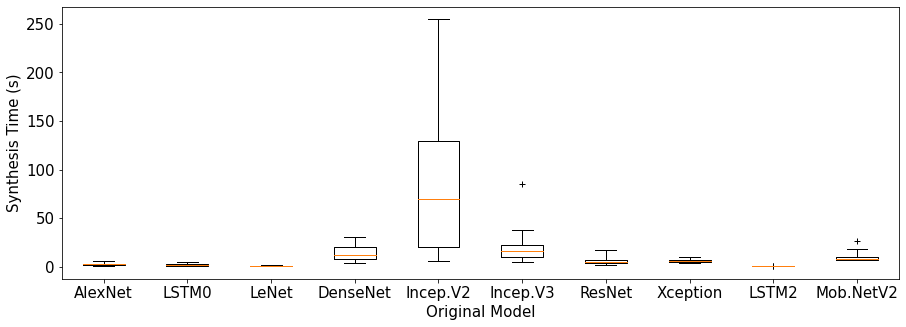

In [14]:
# Draw the barchart
import matplotlib.pyplot as plt

ATITLE_SIZE = 15
LABEL_SIZE = 15
XTICK_SIZE = 15
YTICK_SIZE = 15
LEGEND_SIZE = 15
FTITLA_SIZE = 20
SCATTER_FONT_SIZE = 14
SCATTER_LINE_SIZE = 2.5
SCATTER_AREA = 100

# plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=ATITLE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LABEL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=XTICK_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=YTICK_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=LEGEND_SIZE)    # legend fontsize
plt.rc('figure', titlesize=FTITLA_SIZE)  # fontsize of the figure title
plt.subplots(figsize = (15, 5))
rng = np.random.RandomState(0)

left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.2   # the amount of width reserved for blank space between subplots
hspace = 0.3   # the amount of height reserved for white space between subplots

plt.boxplot(synthesis_dict.values(), notch=0, sym='+', vert=10, whis=5)
# color="#377eb8"
import numpy as np
origin_name_list = list(synthesis_dict.keys())
model_name_dict = {
    "alexnet-cifar10_origin": "AlexNet",
    "lstm0-sinewave_origin": "LSTM0",
    "lenet5-mnist_origin": "LeNet",
    "densenet121-imagenet_origin": "DenseNet",
    "inception.resnet.v2-imagenet_origin": "Incep.V2",
    "inception.v3-imagenet_origin": "Incep.V3",
    "resnet50-imagenet_origin": "ResNet",
    "xception-imagenet_origin": "Xception",
    "lstm2-price_origin": "LSTM2",
    "mobilenet.v2-imagenet_origin": "Mob.NetV2"
}
new_origin_name = []
for name in origin_name_list:
    new_origin_name.append(model_name_dict[name])
plt.xticks(np.arange(1,len(synthesis_dict)+1), new_origin_name)
plt.xlabel("Original Model")
plt.ylabel("Synthesis Time (s)")
plt.savefig("Model_Synthesis_Efficiency.pdf",bbox_inches='tight')

